In [38]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import pickle
from scipy import stats
from functools import partial
from numba import njit

In [2]:
import pystan

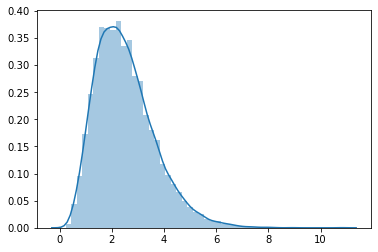

In [7]:
# np.random.gamma(2.5, 0.5, size=10000)
sns.distplot(np.random.gamma(5, 0.5, size=10000))

# Stan-friendly prior

In [13]:
def bounded_prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # v_c ~ U(0.1, 7.0)
    # a_c ~ U(0.1, 4.0)
    # t0 ~ U(0.1, 3.0)
    
    p_samples = np.random.uniform(low=(0.3, 0.3, 0.75, 0.5, 0.3),
                                  high=(2.0, 2.0, 2.0, 2.0, 1.0), size=(batch_size, 5))
    return p_samples.astype(np.float32)


def unbounded_prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    
    p_samples = np.random.gamma(5, 0.5, size=(batch_size, 5))
    return p_samples.astype(np.float32)


@njit
def diffusion_trial(v, a, ndt, zr, dt, max_steps):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    x = a * zr
    rho = np.sqrt(dt)

    # Simulate a single DM path
    while (x > 0 and x < a and n_steps < max_steps):

        # DDM equation
        x += v*dt +  rho * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt
    return rt + ndt if x > 0. else -rt - ndt

@njit
def diffusion_condition(n_trials, v, a, ndt, zr=0.5, dt=0.005, max_steps=1e4):
    """Simulates a diffusion process over an entire condition."""

    x = np.empty(n_trials)
    for i in range(n_trials):
        x[i] = diffusion_trial(v, a, ndt, zr, dt, max_steps)
    return x


@njit
def diffusion_2_conds(params, n_trials, dt=0.001, max_steps=1e4):
    """
    Simulates a diffusion process for 2 conditions with 5 parameters (v1, v2, a1, a2, ndt).
    """

    n_trials_c1 = n_trials[0]
    n_trials_c2 = n_trials[1]

    v1, v2, a1, a2, ndt = params
    rt_c1 = diffusion_condition(n_trials_c1, v1, a1, ndt,  dt=dt, max_steps=max_steps)
    rt_c2 = diffusion_condition(n_trials_c2, v2, a2, ndt, dt=dt, max_steps=max_steps)
    rts = np.concatenate((rt_c1, rt_c2))
    return rts


def batch_simulator(prior_samples, n_obs, dt=0.001, s=1.0, max_iter=1e4):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_data = np.empty((n_sim, n_obs), dtype=np.float32)

    n1 = n_obs//2
    n2 = n_obs - n1

    # Simulate diffusion data 
    for i in range(n_sim):
        sim_data[i] = diffusion_2_conds(prior_samples[i], (n1, n2))

    # Create condition labels
    cond_arr = np.stack(n_sim * [np.concatenate((np.zeros(n1), np.ones(n2)))] )
    sim_data = np.stack((sim_data, cond_arr), axis=-1)

    return sim_data

# Stan Model

In [18]:
stan_model = """
data {
  int<lower=0> N;                    
  real<lower=0> x1[N];   
  real<lower=0> x2[N];   
  int<lower=0,upper=1> resp1[N];  
  int<lower=0,upper=1> resp2[N];  
}

parameters {
  real<lower=0> drift1;
  real<lower=0> drift2;
  real<lower=0> bs1; 
  real<lower=0> bs2; 
  real<lower=0> ndt;
}

model {
  // Ndt-prior min-max

  // Priors
  drift1 ~ gamma(5, 0.5);
  drift2 ~ gamma(5, 0.5);
  bs1 ~ gamma(5, 0.5);
  bs2 ~ gamma(5, 0.5);
  ndt ~ gamma(5, 0.5);
  
  // First condition
  for (n in 1:N) {
     if (resp1[n] == 1) {
        x1[n] ~ wiener(bs1, ndt, 0.5, drift1);
     } 
     else {
        x1[n] ~ wiener(bs1, ndt, 1 - 0.5, -drift1);
     }
  }
  
  // Second condition
  for (n in 1:N) {
     if (resp2[n] == 1) {
        x2[n] ~ wiener(bs2, ndt, 0.5, drift2);
     } 
     else {
        x2[n] ~ wiener(bs2, ndt, 1 - 0.5, -drift2);
     }
  }
}
"""

# Helper functions

In [19]:
# Format for stan
def to_stan(sim_data):
    x1 = sim_data[sim_data[:, 1] == 0, 0]
    x2 = sim_data[sim_data[:, 1] == 1, 0]
    resp1 = (x1 >= 0).astype(np.int64)
    resp2 = (x2 >= 0).astype(np.int64)
    x1 = np.abs(x1).astype(np.float64)
    x2 = np.abs(x2).astype(np.float64)
    return {'x1': x1, 'x2': x2, 'resp1': resp1, 'resp2': resp2, 'N': x1.shape[0]}

def params_to_dict(params):
    
    return {'drift1': params[0],
            'drift2': params[1],
            'bs1': params[2],
            'bs2': params[3],
            'ndt': params[4]}

def contamination_dist_fast_guesses(percentiles, n):    
    return np.random.uniform(0.0, percentiles[10], n)

def contamination_dist_slow_responses(percentiles, n):
    return np.random.uniform(percentiles[75], 10.0, n)

def contamination_dist_fast_and_slow(percentiles, n):
    n1 = int(n/2)
    n2 = n-n1
    fast = contamination_dist_fast_guesses(percentiles, n1)
    slow = contamination_dist_slow_responses(percentiles, n2)
    return np.concatenate((fast, slow))

def contaminate(x, contamination_dist, c=0.1):
    """
    Contaminate the random variate vector x with contaminants according to fraction c \in [0, 1]
    """
    #x_contamination = x.copy()
    
    if not x.size > 0:
        return x

    
    n = x.shape[0]
    n_contamination = int(n * c)
    contamination_idx = np.random.default_rng().choice(n, size=n_contamination, replace=False)
    
    percentiles = np.percentile(x, range(101))
    
    sampled_contamination = contamination_dist(percentiles, n_contamination)
    assert sampled_contamination.shape[0] == n_contamination
    
    
    x[contamination_idx] = sampled_contamination
    return x

def split_posneg_contaminate(x, contamination_dist, c):
    pos_idx = np.where(x>=0)
    neg_idx = np.where(x<0)
    
    x[pos_idx] = contaminate(x[pos_idx], contamination_dist=contamination_dist, c=c)
    x[neg_idx] = contaminate(x[neg_idx], contamination_dist=contamination_dist, c=c)
    return x

def contaminate_dm_data(x, contamination_dist, c=0.1):
    x_copy = x.copy()
    n_sim, n_obs, data_dim = x_copy.shape
    for bi in range(n_sim):
        x_copy[bi, :(n_obs//2), 0] = split_posneg_contaminate(x_copy[bi, :(n_obs//2), 0], contamination_dist, c=c)
        x_copy[bi, (n_obs//2):, 0] = split_posneg_contaminate(x_copy[bi, (n_obs//2):, 0], contamination_dist, c=c)
    return x_copy

# Simulate and contaminate data

In [20]:
np.random.seed(42)
params = unbounded_prior(100)
data_clean = batch_simulator(params, n_obs=100)
data_slow = contaminate_dm_data(data_clean, contamination_dist=contamination_dist_slow_responses, c=0.1)
data_fast = contaminate_dm_data(data_clean, contamination_dist=contamination_dist_fast_guesses, c=0.1)
data_fast_slow = contaminate_dm_data(data_clean, contamination_dist=contamination_dist_fast_and_slow, c=0.1)

# Compile stan model and perform inference

In [21]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08d85dd2ea054476fe2ff1d91f0b0ec9 NOW.


In [22]:
# data_i = to_stan(data_slow[0])
data_i = to_stan(data_clean[0])

In [33]:
ndt_init = min(data_i['x2'].min(), data_i['x1'].min()) * .75
init = {'ndt': ndt_init}
fit = sm.sampling(data=data_i, iter=2000, chains=4, 
                  n_jobs=4, control=dict(adapt_delta=0.99, max_treedepth=15), init=[init, init, init, init])

## Estimate posterior for slow contamination

In [35]:
%%time
stan_post_samples_slow = []
for idx in range(data_clean.shape[0]):
    data_i = to_stan(data_slow[idx])
    ndt_init = min(data_i['x2'].min(), data_i['x1'].min()) * .75
    init = {'ndt': ndt_init}
    fit = sm.sampling(data=data_i, 
                      iter=2000, chains=4, n_jobs=4, init=[init, init, init, init],
                      control=dict(adapt_delta=0.99, max_treedepth=15))
    samples = fit.extract(permuted=True)
    stan_post_samples_slow.append(samples)
    print(f'Finished estimating data set {idx+1}...')

Finished estimating data set 1...
Finished estimating data set 2...
Finished estimating data set 3...
Finished estimating data set 4...
Finished estimating data set 5...
Finished estimating data set 6...
Finished estimating data set 7...
Finished estimating data set 8...
Finished estimating data set 9...
Finished estimating data set 10...
Finished estimating data set 11...
Finished estimating data set 12...
Finished estimating data set 13...
Finished estimating data set 14...
Finished estimating data set 15...
Finished estimating data set 16...
Finished estimating data set 17...
Finished estimating data set 18...
Finished estimating data set 19...
Finished estimating data set 20...
Finished estimating data set 21...
Finished estimating data set 22...
Finished estimating data set 23...
Finished estimating data set 24...
Finished estimating data set 25...
Finished estimating data set 26...
Finished estimating data set 27...
Finished estimating data set 28...
Finished estimating data set 

## Estimate posterior for fast contamination

In [36]:
stan_post_samples_fast = []
for idx in range(data_clean.shape[0]):
    data_i = to_stan(data_fast[idx])
    ndt_init = min(data_i['x2'].min(), data_i['x1'].min()) * .75
    init = {'ndt': ndt_init}
    fit = sm.sampling(data=data_i, 
                      iter=2000, chains=4, n_jobs=4, init=[init, init, init, init],
                      control=dict(adapt_delta=0.99, max_treedepth=15))
    samples = fit.extract(permuted=True)
    stan_post_samples_fast.append(samples)
    print(f'Finished estimating data set {idx+1}...')

Finished estimating data set 1...
Finished estimating data set 2...
Finished estimating data set 3...
Finished estimating data set 4...
Finished estimating data set 5...
Finished estimating data set 6...
Finished estimating data set 7...
Finished estimating data set 8...
Finished estimating data set 9...
Finished estimating data set 10...
Finished estimating data set 11...
Finished estimating data set 12...
Finished estimating data set 13...
Finished estimating data set 14...
Finished estimating data set 15...
Finished estimating data set 16...
Finished estimating data set 17...
Finished estimating data set 18...
Finished estimating data set 19...
Finished estimating data set 20...
Finished estimating data set 21...
Finished estimating data set 22...
Finished estimating data set 23...
Finished estimating data set 24...
Finished estimating data set 25...
Finished estimating data set 26...
Finished estimating data set 27...
Finished estimating data set 28...
Finished estimating data set 

Finished estimating data set 92...
Finished estimating data set 93...
Finished estimating data set 94...
Finished estimating data set 95...
Finished estimating data set 96...
Finished estimating data set 97...
Finished estimating data set 98...
Finished estimating data set 99...
Finished estimating data set 100...


## Estimate posteriors for slow and fast

In [37]:
stan_post_samples_fast_slow = []
for idx in range(data_clean.shape[0]):
    data_i = to_stan(data_fast_slow[idx])
    ndt_init = min(data_i['x2'].min(), data_i['x1'].min()) * .75
    init = {'ndt': ndt_init}
    fit = sm.sampling(data=data_i, 
                      iter=2000, chains=4, n_jobs=4, init=[init, init, init, init],
                      control=dict(adapt_delta=0.99, max_treedepth=15))
    samples = fit.extract(permuted=True)
    stan_post_samples_fast_slow.append(samples)
    print(f'Finished estimating data set {idx+1}...')

Finished estimating data set 1...
Finished estimating data set 2...
Finished estimating data set 3...
Finished estimating data set 4...
Finished estimating data set 5...
Finished estimating data set 6...
Finished estimating data set 7...
Finished estimating data set 8...
Finished estimating data set 9...
Finished estimating data set 10...
Finished estimating data set 11...
Finished estimating data set 12...
Finished estimating data set 13...
Finished estimating data set 14...
Finished estimating data set 15...
Finished estimating data set 16...
Finished estimating data set 17...
Finished estimating data set 18...
Finished estimating data set 19...
Finished estimating data set 20...
Finished estimating data set 21...
Finished estimating data set 22...
Finished estimating data set 23...
Finished estimating data set 24...
Finished estimating data set 25...
Finished estimating data set 26...
Finished estimating data set 27...
Finished estimating data set 28...
Finished estimating data set 

## Estimate posteriors for clean

In [39]:
stan_post_samples_clean = []
for idx in range(data_clean.shape[0]):
    data_i = to_stan(data_clean[idx])
    ndt_init = min(data_i['x2'].min(), data_i['x1'].min()) * .75
    init = {'ndt': ndt_init}
    fit = sm.sampling(data=data_i, 
                      iter=2000, chains=4, n_jobs=4, init=[init, init, init, init],
                      control=dict(adapt_delta=0.99, max_treedepth=15))
    samples = fit.extract(permuted=True)
    stan_post_samples_clean.append(samples)
    print(f'Finished estimating data set {idx+1}...')

Finished estimating data set 1...
Finished estimating data set 2...
Finished estimating data set 3...
Finished estimating data set 4...
Finished estimating data set 5...
Finished estimating data set 6...
Finished estimating data set 7...
Finished estimating data set 8...
Finished estimating data set 9...
Finished estimating data set 10...
Finished estimating data set 11...
Finished estimating data set 12...
Finished estimating data set 13...
Finished estimating data set 14...
Finished estimating data set 15...
Finished estimating data set 16...
Finished estimating data set 17...
Finished estimating data set 18...
Finished estimating data set 19...
Finished estimating data set 20...
Finished estimating data set 21...
Finished estimating data set 22...
Finished estimating data set 23...
Finished estimating data set 24...
Finished estimating data set 25...
Finished estimating data set 26...
Finished estimating data set 27...
Finished estimating data set 28...
Finished estimating data set 

In [ ]:
# Remove posteriors of data set idx 91 due to a high percentage of divergences

## Serialize

In [41]:
stan_post_samples_clean_c = [s for i,s in enumerate(stan_post_samples_clean) if i != 91]
stan_post_samples_slow_c = [s for i,s in enumerate(stan_post_samples_slow) if i != 91]
stan_post_samples_fast_c = [s for i,s in enumerate(stan_post_samples_fast) if i != 91]
stan_post_samples_fast_slow_c = [s for i,s in enumerate(stan_post_samples_fast_slow) if i != 91]

In [50]:
pickle.dump(
{
    'clean': stan_post_samples_clean_c, 
    'slow': stan_post_samples_slow_c, 
    'fast': stan_post_samples_fast_c, 
    'fast_slow': stan_post_samples_fast_slow_c, 
    }, 
    open('./export_stan_posteriors/stan_posteriors.pkl', 'wb+')
)

In [51]:
pickle.dump(
{
    'clean': np.delete(data_clean, 91, axis=0), 
    'slow': np.delete(data_slow, 91, axis=0), 
    'fast': np.delete(data_fast, 91, axis=0), 
    'fast_slow': np.delete(data_fast_slow, 91, axis=0), 
    }, 
    open('./export_stan_posteriors/data_posteriors.pkl', 'wb+')
)